In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
import tensorflow as tf
from keras import Model
from keras.layers import Input, Dense, Dropout
from keras.layers import LSTM

In [17]:
df = pd.read_csv('Gold Futures Historical Data (1).csv')


In [18]:
df

,Date,Price,Open,High,Low,Vol.,Change %
0,12/29/2023,"2,071.80","2,076.10","2,084.10","2,067.60",105.72K,-0.56%
1,12/28/2023,"2,083.50","2,089.50","2,098.20","2,074.60",129.54K,0.00%
2,12/27/2023,"2,083.40","2,068.00","2,085.30","2,063.30",0.59K,1.12%
3,12/26/2023,"2,060.40","2,056.30","2,069.60","2,056.30",0.29K,-0.30%
4,12/25/2023,"2,066.65","2,065.30","2,067.60","2,065.30",NaN,0.34%
...,...,...,...,...,...,...,...
2842,01/08/2013,"1,662.20","1,647.60","1,662.70","1,646.80",146.84K,0.97%
2843,01/07/2013,"1,646.30","1,656.30","1,663.00","1,642.60",140.82K,-0.16%
2844,01/04/2013,"1,648.90","1,663.80","1,664.50","1,626.00",252.73K,-1.53%
2845,01/03/2013,"1,674.60","1,686.20","1,690.50","1,661.20",143.79K,-0.84%


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2847 entries, 0 to 2846
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Date      2847 non-null   object
 1   Price     2847 non-null   object
 2   Open      2847 non-null   object
 3   High      2847 non-null   object
 4   Low       2847 non-null   object
 5   Vol.      2830 non-null   object
 6   Change %  2847 non-null   object
dtypes: object(7)
memory usage: 155.8+ KB


Summary Statistics:
                                Date        Price         Open         High  \
count                           2847  2847.000000  2847.000000  2847.000000   
mean   2018-07-07 01:51:46.849315072  1487.711416  1488.080822  1498.202950   
min              2013-01-02 00:00:00  1049.600000  1051.500000  1062.700000   
25%              2015-10-03 12:00:00  1252.000000  1252.600000  1259.150000   
50%              2018-07-09 00:00:00  1336.800000  1337.100000  1345.700000   
75%              2021-04-12 12:00:00  1783.900000  1784.250000  1797.350000   
max              2023-12-29 00:00:00  2089.700000  2094.400000  2152.300000   
std                              NaN   287.409869   287.486370   289.688338   

               Low           Vol.     Change %  
count  2847.000000    2830.000000  2847.000000  
mean   1477.235494  203500.067138     0.012160  
min    1045.400000       0.000000    -9.340000  
25%    1243.900000  141590.000000    -0.440000  
50%    1327.700000  188

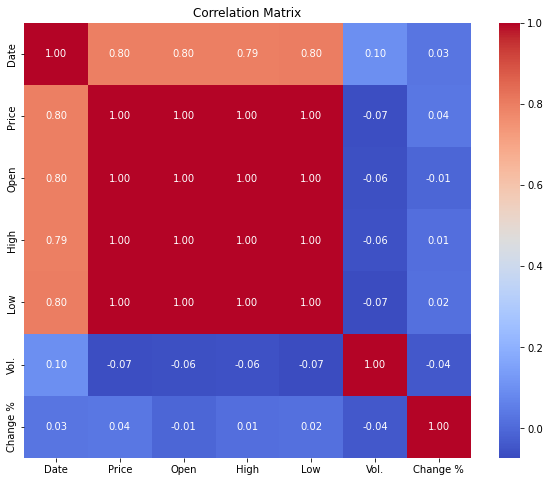

In [20]:
# Step 1: Load the CSV file into a pandas DataFrame
file_path = 'Gold Futures Historical Data (1).csv'
data = pd.read_csv(file_path)

# Step 2: Clean the data (if necessary) and handle missing values
# Convert 'Date' column to datetime
data['Date'] = pd.to_datetime(data['Date'])

# Convert 'Price', 'Open', 'High', 'Low' columns to numeric after removing commas
data['Price'] = data['Price'].replace('[\$,]', '', regex=True).astype(float)
data['Open'] = data['Open'].replace('[\$,]', '', regex=True).astype(float)
data['High'] = data['High'].replace('[\$,]', '', regex=True).astype(float)
data['Low'] = data['Low'].replace('[\$,]', '', regex=True).astype(float)

# Convert 'Vol.' column to numeric after removing 'K' and 'M'
data['Vol.'] = data['Vol.'].replace('[KM]', '', regex=True).astype(float) * \
               data['Vol.'].str.extract(r'[\d\.]+([KM]+)', expand=False).fillna(1).replace(['K','M'], [10**3, 10**6]).astype(int)

# Convert 'Change %' column to numeric after removing '%'
data['Change %'] = data['Change %'].replace('%', '', regex=True).astype(float)

# Step 3: Calculate and display interesting statistics
print("Summary Statistics:")
print(data.describe())

# Step 4: Explore correlations between different columns
correlation_matrix = data.corr()
print("\nCorrelation Matrix:")
print(correlation_matrix)

# Step 5: Visualize correlations using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()



In [21]:
df.drop(['Vol.', 'Change %'], axis=1, inplace=True)


In [22]:
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values(by='Date', ascending=True, inplace=True)
df.reset_index(drop=True, inplace=True)

In [23]:
NumCols = df.columns.drop(['Date'])
df[NumCols] = df[NumCols].replace({',': ''}, regex=True)
df[NumCols] = df[NumCols].astype('float64')

In [24]:
df.head()

,Date,Price,Open,High,Low
0,2013-01-02,1688.8,1676.4,1695.4,1670.9
1,2013-01-03,1674.6,1686.2,1690.5,1661.2
2,2013-01-04,1648.9,1663.8,1664.5,1626.0
3,2013-01-07,1646.3,1656.3,1663.0,1642.6
4,2013-01-08,1662.2,1647.6,1662.7,1646.8


In [25]:
df.duplicated().sum()
df.isnull().sum().sum()

0

# Step 5: Visualizing Gold Price History Data¶


In [26]:
fig = px.line(y=df.Price, x=df.Date)
fig.update_traces(line_color='black') 
fig.update_layout(xaxis_title="Date", 
                  yaxis_title="Scaled Price",
                  title={'text': "Gold Price History Data", 'y':0.95, 'x':0.5, 'xanchor':'center', 'yanchor':'top'},
                  plot_bgcolor='rgba(255,223,0,0.8)')

In [27]:
total_size = df.shape[0]


In [28]:
test_size = df[df.Date.dt.year == 2023].shape[0]


In [29]:
train_size = total_size - test_size


نسبة مجموعة التدريب: 90.73%
نسبة مجموعة الاختبار: 9.27%


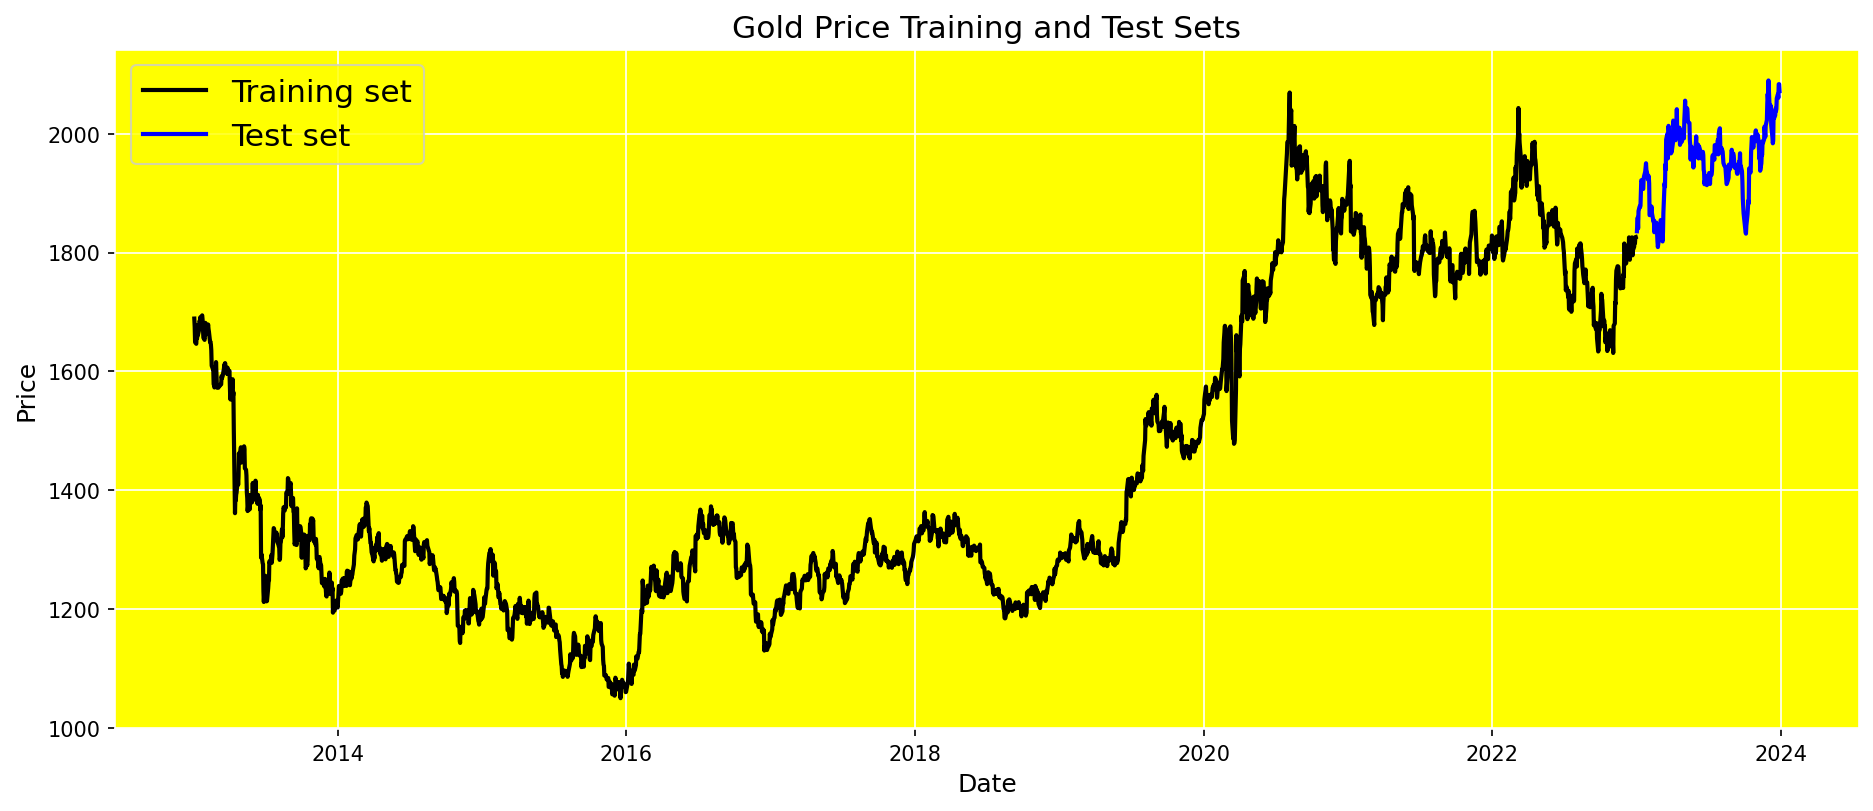

In [30]:
import matplotlib.pyplot as plt

# حساب الحجم الإجمالي للبيانات
total_size = df.shape[0]

# حساب حجم مجموعة الاختبار (البيانات من عام 2023)
test_size = df[df.Date.dt.year == 2023].shape[0]

# حساب حجم مجموعة التدريب
train_size = total_size - test_size

# حساب النسبة المئوية لكل من مجموعة التدريب والاختبار
train_percentage = (train_size / total_size) * 100
test_percentage = (test_size / total_size) * 100

# طباعة النسب المئوية
print(f"نسبة مجموعة التدريب: {train_percentage:.2f}%")
print(f"نسبة مجموعة الاختبار: {test_percentage:.2f}%")

# رسم البيانات
plt.figure(figsize=(15, 6), dpi=150)
plt.rcParams['axes.facecolor'] = 'yellow'
plt.rc('axes', edgecolor='white')
plt.plot(df.Date[:-test_size], df.Price[:-test_size], color='black', lw=2)
plt.plot(df.Date[-test_size:], df.Price[-test_size:], color='blue', lw=2)
plt.title('Gold Price Training and Test Sets', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend(['Training set', 'Test set'], loc='upper left', prop={'size': 15})
plt.grid(color='white')
plt.show()


# Step 6: Splitting Data to Training & Test Sets

In [31]:
test_size = df[df.Date.dt.year==2023].shape[0]
test_size

264

Gold Price Training and Test Sets Plot:

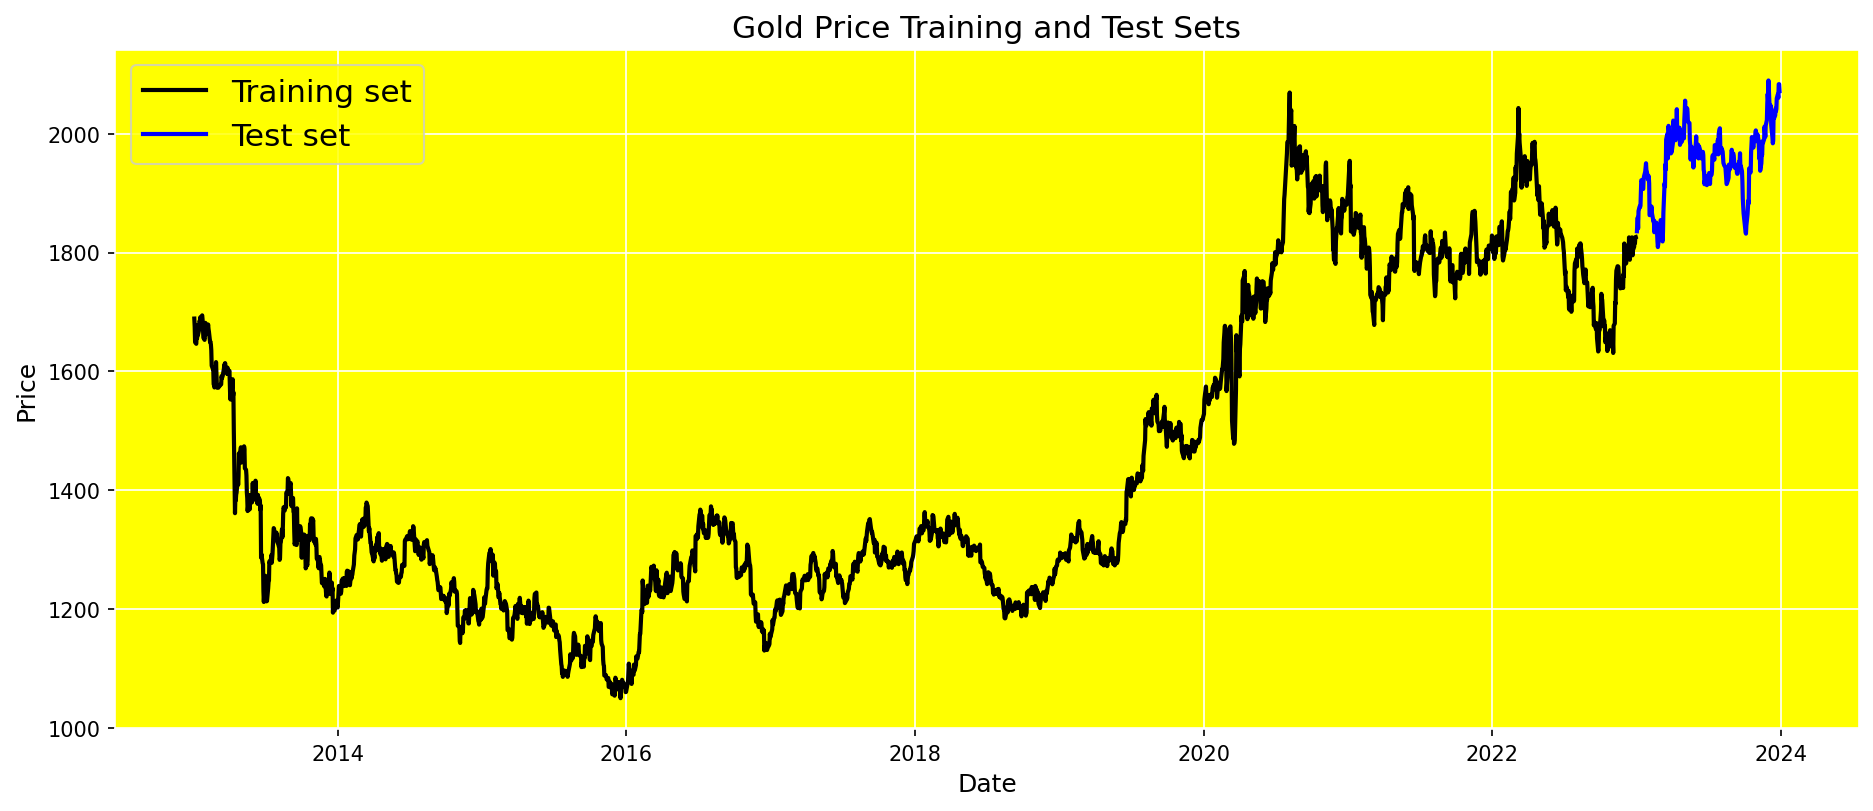

In [32]:
plt.figure(figsize=(15, 6), dpi=150)
plt.rcParams['axes.facecolor'] = 'yellow'
plt.rc('axes',edgecolor='white')
plt.plot(df.Date[:-test_size], df.Price[:-test_size], color='black', lw=2)
plt.plot(df.Date[-test_size:], df.Price[-test_size:], color='blue', lw=2)
plt.title('Gold Price Training and Test Sets', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend(['Training set', 'Test set'], loc='upper left', prop={'size': 15})
plt.grid(color='white')
plt.show()

# 4.7 Feature engineering

# 4.7.1 Data Scaling

4.7.1 Data Scaling

In [33]:
scaler = MinMaxScaler()
scaler.fit(df.Price.values.reshape(-1,1))

MinMaxScaler()

4.7.2 Restructure Data & Create Sliding Window

In [34]:
window_size = 60


In [35]:
train_data = df.Price[:-test_size]
train_data = scaler.transform(train_data.values.reshape(-1,1))

In [36]:
X_train = []
y_train = []

for i in range(window_size, len(train_data)):
    X_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

In [37]:
test_data = df.Price[-test_size-60:]
test_data = scaler.transform(test_data.values.reshape(-1,1))

In [38]:
X_test = []
y_test = []

for i in range(window_size, len(test_data)):
    X_test.append(test_data[i-60:i, 0])
    y_test.append(test_data[i, 0])

4.8.3 Converting Data to Numpy Arrays

In [39]:
X_train = np.array(X_train)
X_test  = np.array(X_test)
y_train = np.array(y_train)
y_test  = np.array(y_test)

In [40]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test  = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
y_train = np.reshape(y_train, (-1,1))
y_test  = np.reshape(y_test, (-1,1))

In [41]:
print('X_train Shape: ', X_train.shape)
print('y_train Shape: ', y_train.shape)
print('X_test Shape:  ', X_test.shape)
print('y_test Shape:  ', y_test.shape)

X_train Shape:  (2523, 60, 1)
y_train Shape:  (2523, 1)
X_test Shape:   (264, 60, 1)
y_test Shape:   (264, 1)


# 4.8  MODELLING

4.8.1 ARIMA(AutoRegressive Integrated Moving Average)

4.8.2  LSTM Network(Long Short-Term Memory)

In [42]:
def define_model():
    input1 = Input(shape=(window_size,1))
    x = LSTM(units = 64, return_sequences=True)(input1)  
    x = Dropout(0.2)(x)
    x = LSTM(units = 64, return_sequences=True)(x)
    x = Dropout(0.2)(x)
    x = LSTM(units = 64)(x)
    x = Dropout(0.2)(x)
    x = Dense(32, activation='softmax')(x)
    dnn_output = Dense(1)(x)

    model = Model(inputs=input1, outputs=[dnn_output])
    model.compile(loss='mean_squared_error', optimizer='Nadam')
    model.summary()
    
    return model

In [43]:
model = define_model()
history = model.fit(X_train, y_train, epochs=150, batch_size=32, validation_split=0.1, verbose=1)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 60, 1)]           0         
                                                                 
 lstm (LSTM)                 (None, 60, 64)            16896     
                                                                 
 dropout (Dropout)           (None, 60, 64)            0         
                                                                 
 lstm_1 (LSTM)               (None, 60, 64)            33024     
                                                                 
 dropout_1 (Dropout)         (None, 60, 64)            0         
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout_2 (Dropout)         (None, 64)                0     

71/71 [==============================] - 5s 68ms/step - loss: 3.8890e-04 - val_loss: 8.3539e-04
Epoch 64/150
71/71 [==============================] - 5s 63ms/step - loss: 3.9153e-04 - val_loss: 5.6711e-04
Epoch 65/150
71/71 [==============================] - 5s 73ms/step - loss: 3.8593e-04 - val_loss: 8.0613e-04
Epoch 66/150
71/71 [==============================] - 5s 68ms/step - loss: 3.9272e-04 - val_loss: 7.9798e-04
Epoch 67/150
71/71 [==============================] - 5s 67ms/step - loss: 3.8255e-04 - val_loss: 8.9811e-04
Epoch 68/150
71/71 [==============================] - 5s 74ms/step - loss: 3.8302e-04 - val_loss: 7.7786e-04
Epoch 69/150
71/71 [==============================] - 5s 72ms/step - loss: 3.5422e-04 - val_loss: 0.0011
Epoch 70/150
71/71 [==============================] - 5s 74ms/step - loss: 3.7763e-04 - val_loss: 6.1043e-04
Epoch 71/150
71/71 [==============================] - 5s 70ms/step - loss: 3.5140e-04 - val_loss: 8.3205e-04
Epoch 72/150
71/71 [================

71/71 [==============================] - 4s 63ms/step - loss: 2.9842e-04 - val_loss: 0.0011
Epoch 139/150
71/71 [==============================] - 5s 65ms/step - loss: 2.7495e-04 - val_loss: 8.2547e-04
Epoch 140/150
71/71 [==============================] - 4s 63ms/step - loss: 2.9648e-04 - val_loss: 8.1531e-04
Epoch 141/150
71/71 [==============================] - 5s 73ms/step - loss: 2.6229e-04 - val_loss: 8.1142e-04
Epoch 142/150
71/71 [==============================] - 5s 69ms/step - loss: 2.6790e-04 - val_loss: 0.0010
Epoch 143/150
71/71 [==============================] - 5s 68ms/step - loss: 2.6588e-04 - val_loss: 0.0010
Epoch 144/150
71/71 [==============================] - 5s 67ms/step - loss: 2.7094e-04 - val_loss: 0.0012
Epoch 145/150
71/71 [==============================] - 5s 65ms/step - loss: 2.7153e-04 - val_loss: 9.8483e-04
Epoch 146/150
71/71 [==============================] - 5s 68ms/step - loss: 2.9882e-04 - val_loss: 8.4919e-04
Epoch 147/150
71/71 [===================

In [44]:
result = model.evaluate(X_test, y_test)
y_pred = model.predict(X_test) 

9/9 [==============================] - 1s 18ms/step


In [45]:
MAPE = mean_absolute_percentage_error(y_test, y_pred)
Accuracy = 1 - MAPE

In [46]:
print("Test Loss:", result)
print("Test MAPE:", MAPE)
print("Test Accuracy:", Accuracy)

Test Loss: 0.0008044942514970899
Test MAPE: 0.023403465499132733
Test Accuracy: 0.9765965345008673


# 5.2 Visualizing Results

In [47]:
y_test_true = scaler.inverse_transform(y_test)
y_test_pred = scaler.inverse_transform(y_pred)

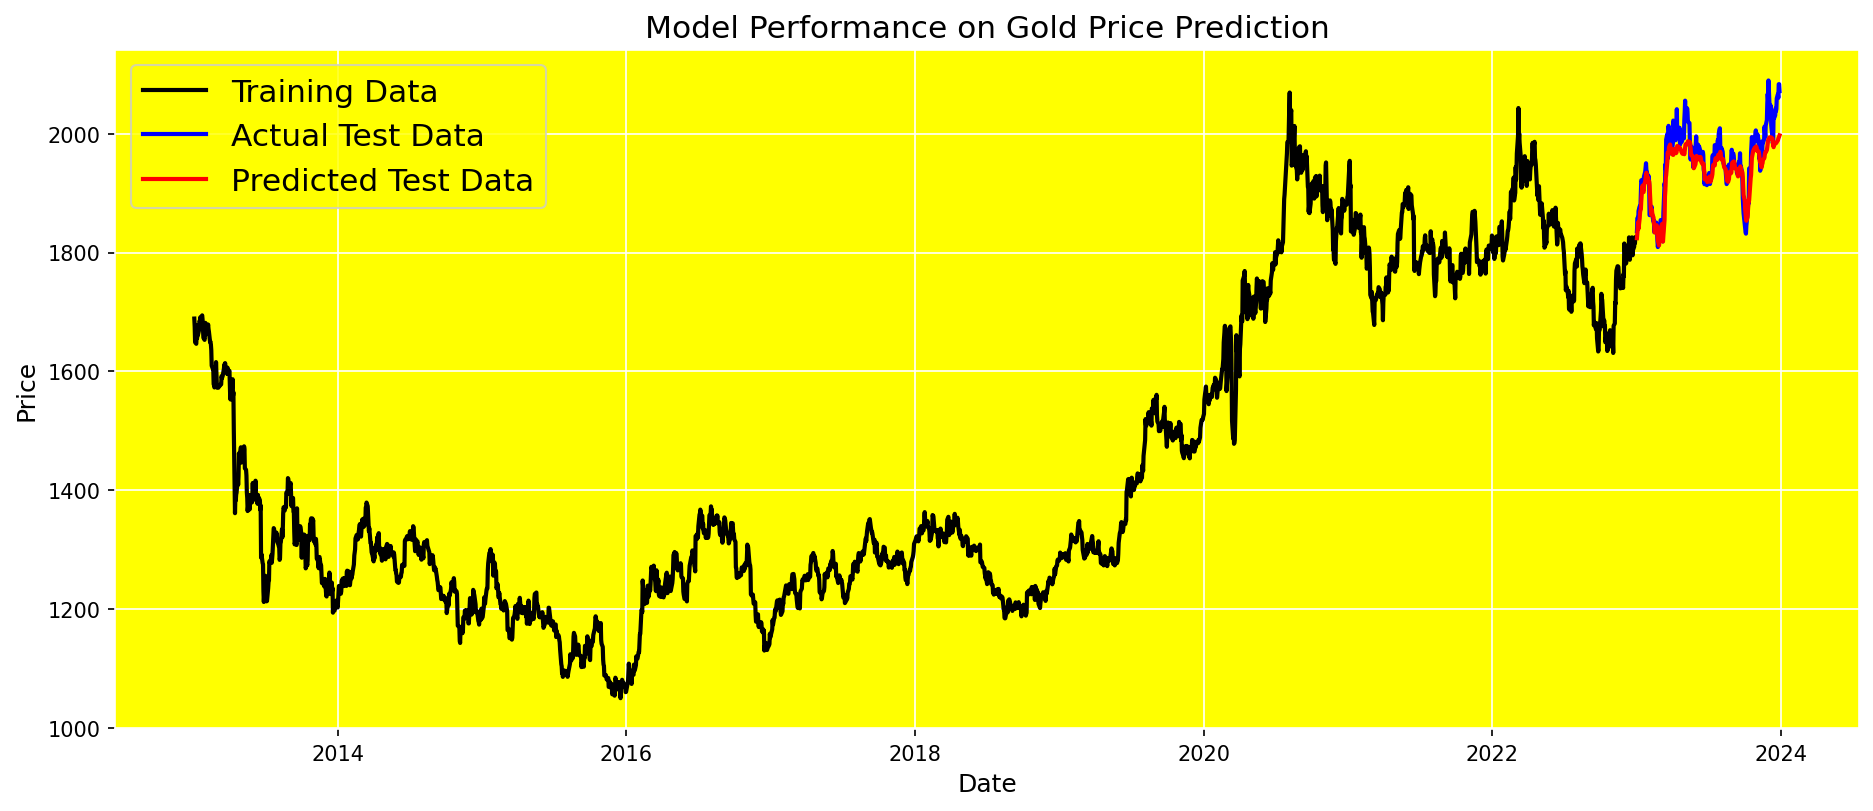

In [48]:
plt.figure(figsize=(15, 6), dpi=150)
plt.rcParams['axes.facecolor'] = 'yellow'
plt.rc('axes',edgecolor='white')
plt.plot(df['Date'].iloc[:-test_size], scaler.inverse_transform(train_data), color='black', lw=2)
plt.plot(df['Date'].iloc[-test_size:], y_test_true, color='blue', lw=2)
plt.plot(df['Date'].iloc[-test_size:], y_test_pred, color='red', lw=2)
plt.title('Model Performance on Gold Price Prediction', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend(['Training Data', 'Actual Test Data', 'Predicted Test Data'], loc='upper left', prop={'size': 15})
plt.grid(color='white')
plt.show()

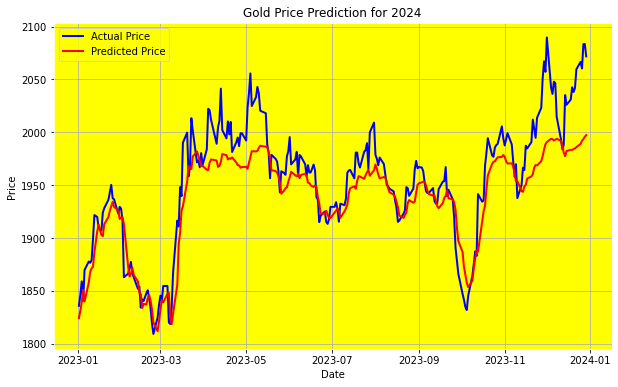

In [49]:
import matplotlib.pyplot as plt
import plotly.express as px

# رسم البيانات المتنبأ بها والبيانات الفعلية لعام 2024 باستخدام Matplotlib
plt.figure(figsize=(10, 6))
plt.plot(df['Date'].iloc[-test_size:], y_test_true, color='blue', lw=2, label='Actual Price')
plt.plot(df['Date'].iloc[-test_size:], y_test_pred, color='red', lw=2, label='Predicted Price')
plt.title('Gold Price Prediction for 2024')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

# إنشاء DataFrame للبيانات المتوقعة لعام 2024
predicted_data_2024 = pd.DataFrame({'Date': df['Date'].iloc[-test_size:], 'Predicted Price': y_test_pred.flatten()})

# رسم البيانات المتوقعة لعام 2024 باستخدام Plotly
fig = px.line(predicted_data_2024, x='Date', y='Predicted Price', title='Predicted Gold Price for 2024')
fig.show()


In [50]:
# Print the predicted prices and actual prices for 2024
for date, actual_price, predicted_price in zip(df['Date'].iloc[-test_size:], y_test_true, y_test_pred):
    print(f"Date: {date}, Actual Price: {actual_price}, Predicted Price: {predicted_price}")


Date: 2023-01-02 00:00:00, Actual Price: [1835.8], Predicted Price: [1824.1768]
Date: 2023-01-03 00:00:00, Actual Price: [1846.1], Predicted Price: [1831.1609]
Date: 2023-01-04 00:00:00, Actual Price: [1859.], Predicted Price: [1839.4602]
Date: 2023-01-05 00:00:00, Actual Price: [1840.6], Predicted Price: [1850.9657]
Date: 2023-01-06 00:00:00, Actual Price: [1869.7], Predicted Price: [1839.926]
Date: 2023-01-09 00:00:00, Actual Price: [1877.8], Predicted Price: [1857.7239]
Date: 2023-01-10 00:00:00, Actual Price: [1876.5], Predicted Price: [1867.9137]
Date: 2023-01-11 00:00:00, Actual Price: [1878.9], Predicted Price: [1871.245]
Date: 2023-01-12 00:00:00, Actual Price: [1898.8], Predicted Price: [1872.7427]
Date: 2023-01-13 00:00:00, Actual Price: [1921.7], Predicted Price: [1886.6544]
Date: 2023-01-15 00:00:00, Actual Price: [1919.9], Predicted Price: [1905.986]
Date: 2023-01-16 00:00:00, Actual Price: [1909.9], Predicted Price: [1912.4728]
Date: 2023-01-17 00:00:00, Actual Price: [19

In [51]:
from sklearn.metrics import r2_score

# Calculate R-squared
r_squared = r2_score(y_test, y_pred)
print("R-squared:", r_squared)


R-squared: 0.7573498544436323
